# Simulation-based Calibration in SBI

After a density estimator has been trained with simulated data to obtain a posterior, the estimator should be made subject to several diagnostic tests, before being used for inference given the actual observed data. *Posterior Predictive Checks* (see tutorial 12) provide one way to "critique" a trained estimator via its predictive performance. Another important approach to such diagnostics is simulation-based calibration as reported by [Talts et al, 2018](https://arxiv.org/abs/1804.06788).

**Simulation-based calibration** (SBC) provides a (qualitative) view and a quantitive measure to check, whether the uncertainties of the posterior are balanced, i.e., neither over-confident nor under-confident. As such, SBC can be viewed as a necessary condition (but not sufficient) for a valid inference algorithm: If SBC checks fail, this tells you that your inference is invalid. If SBC checks pass, this is no guarantee that the posterior estimation is working.

## In a nutshell

To run SBC,  

1. we sample `theta_o_i` values from the prior of the problem at hand
2. we simulate "observations" from these parameters: `x_o_i = simulator(theta_o_i)` 
3. we perform inference given each observation `x_o_i`.

This produces a separate posterior $p_i(\theta | x_{o,i})$ for each of `x_o_i`. The key step for SBC is to generate a set of posterior samples $\{\theta\}_i$ from each posterior (let's call this `theta_i_s`, referring to `s` samples from posterior $p_i(\theta | x_{o,i})$), and to rank the corresponding `theta_o_i` under this set of samples. A rank is computed by counting how many samples `theta_i_s` fall below their corresponding `theta_o_i` (see section 4.1 in Talts et al.). These ranks are then used to perform the SBC check.

### Key ideas behind SBC

The core idea behind SBC is two fold: 

- SBC ranks of ground truth parameters under the inferred posterior samples follow a uniform distribution.  
(If the SBC ranks are not uniformly distributed, the posterior is not well calibrated.)

- samples from the data averaged posterior (ensemble of randomly chosen posterior samples given multiple distinct observations `x_o`) are distributed according to the prior

### What can SBC diagnose?

**SBC can inform us whether we are not wrong.** However, it cannot tell us whether we are right, i.e., SBC checks a necessary condition. For example, imagine you run SBC using the prior as a posterior. The ranks would be perfectly uniform. But the inference would be wrong.

**The Posterior Predictive Checks (see tutorial 12) can be seen as the complementary sufficient check** for the posterior (only as a methaphor, no theoretical guarantees here). Using the prior as a posterior and then doing predictive checks would clearly show that inference failed. 

To summarize SBC can:

- tell us whether the SBI method applied to the problem at hand produces posteriors that have well-calibrated uncertainties,
- and if not, what kind of systematic bias it has: negative or positive bias (shift in the mean of the predictions) or over- or underdispersion (too large or too small variance)

## A healthy posterior

Let's take the gaussian linear simulator from the previous tutorials and run inference with NPE on it. 

__Note:__ SBC requires running inference several times. Using SBC with amortized methods like NPE is hence a justified endavour: repeated inference is cheap and SBC can be performed with little runtime penalty. This does not hold for sequential methods or anything relying on MCMC or VI (here, parallelization is your friend, `num_workers>1`).

In [1]:
import torch

from torch import eye, ones, zeros
from torch.distributions import MultivariateNormal

from sbi.analysis import check_sbc, run_sbc, get_nltp, sbc_rank_plot
from sbi.inference import SNPE, SNPE_C, prepare_for_sbi, simulate_for_sbi
from sbi.simulators import linear_gaussian, diagonal_linear_gaussian

In [2]:
num_dim = 2
num_simulations = 5_000

prior_mean = ones(num_dim)
prior_cov = 2 * eye(num_dim)
prior = MultivariateNormal(
    loc=prior_mean, covariance_matrix=prior_cov, validate_args=False
)

## An ideal case

To explore SBC, we make our life easy and assume that we deal with a problem where the likelihood is modelled by an identity mapping and a bit of smear. But to start, we only use an almost vanishing smear of `0.01`.

In [3]:
default_likelihood_loc = 0.0  # let's start with 0 shift
default_likelihood_scale = 0.01  # let's smear theta only by a little bit


def simulator(theta, loc=default_likelihood_loc, scale=default_likelihood_scale):
    """linear gaussian inspired by sbibm
    https://github.com/sbi-benchmark/sbibm/blob/15f068a08a938383116ffd92b92de50c580810a3/sbibm/tasks/gaussian_linear/task.py#L74
    """
    num_dim = theta.shape[-1]
    cov_ = scale * eye(num_dim)  # always positively semi-definite

    # using validate_args=False disables sanity checks on `covariance_matrix`
    # for the sake of speed
    value = MultivariateNormal(
        loc=(theta + loc), covariance_matrix=cov_, validate_args=False
    ).sample()
    return value


_ = torch.manual_seed(3)
theta, x = simulate_for_sbi(simulator, prior, num_simulations)

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

In [4]:
_ = torch.manual_seed(1)

# let's obtain an observation
theta_o = prior.sample((1,))
x_o = simulator(theta_o)
print("theta:", theta_o.numpy())
print("x    :", x_o.numpy())

theta: [[1.9352932 1.3774877]]
x    : [[1.941461  1.4396194]]


In [6]:
_ = torch.manual_seed(2)

# we use a mdn model to have a fast turnaround with training.
inferer = SNPE(prior, density_estimator="mdn")
# append simulations and run training.
inferer.append_simulations(theta, x).train();

 Neural network successfully converged after 65 epochs.

In [17]:
posterior = inferer.build_posterior()
posterior_samples = posterior.sample((15_000,), x=x_o)
# Generate predictive samples by simulating from posterior samples.
posterior_predictive_samples = simulator(posterior_samples)

Drawing 15000 posterior samples:   0%|          | 0/15000 [00:00<?, ?it/s]

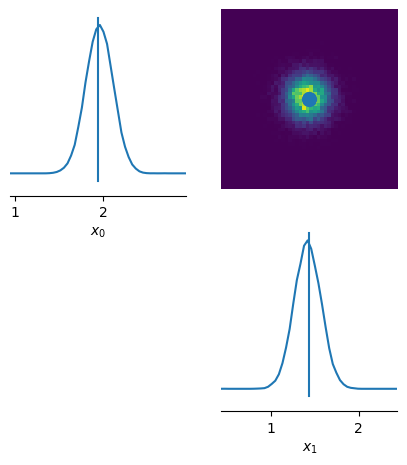

In [8]:
# let's do some posterior predictive checks to see if the
# posterior predictive samples cluster aournd the observation `x_o`.
from sbi.analysis import pairplot

fig, ax = pairplot(
    samples=posterior_predictive_samples,
    points=x_o,
    limits=list(zip(x_o.flatten() - 1.0, x_o.flatten() + 1.0)),
    offdiag="kde",
    diag="kde",
    figsize=(5, 5),
    labels=[rf"$x_{d}$" for d in range(3)],
)

The observation `x_o` falls into the support of the predicted posterior samples, i.e. it is within `simulator(posterior_samples)`. Given the simulator, this is indicative that our posterior estimates the data well.

### Running SBC

We have a working and trained posterior at this point! Hurray! Let's look at the SBC metrics now.

In [9]:
num_sbc_runs = 1_000  # choose a number of sbc runs, should be ~100s or ideally 1000
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = prior.sample((num_sbc_runs,))
xs = simulator(thetas)

SBC is implemented in `sbi` for your use on any `sbi` posterior. To run it, we only need to call `run_sbc` with appropriate parameters. 

__Note__: For amortized neural posteriors (like in this tutorial), execution of `sbc` is expected to be fast. For posteriors that conduct inference with MCMC and hence are slow, `run_sbc` exposes the use of multiple internal parallel workers to the user. To use this feature, add `num_workers = 2` to the parameters for use of two workers. See the API documentation for details.

In [10]:
# run SBC: for each inference we draw 1000 posterior samples.
num_posterior_samples = 1_000
ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples
)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

`sbi` establishes two methods to do simulation-based calibration:

- metrics to compare the sbc ranks with a uniform distribution 
- control plots for visual inspections like fig. 1 or 2 in [Talts et al, 2018](https://arxiv.org/abs/1804.06788)

The `ranks` count is performed per dimension of `theta`, i.e. on the 1-D marginal posterior estimates. According to theory, the distribution of these ranks (per dimension of `theta`) should turn out to be uniformly distributed. 

The data average posterior `dap` (see equation 1 of [Talts et al, 2018](https://arxiv.org/abs/1804.06788)) is yet another metric of interest. It is built from singular random samples of the estimated posterior samples for each `xs` above. The `dap` is expected to match the prior distribution used (see equation 1 in [Talts et al, 2018](https://arxiv.org/abs/1804.06788) too). 

In [11]:
check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)

The `check_stats` variable created contains a dictionary with 3 metrics that help to judge our posterior. The "first" two compare the ranks to a uniform distribution.

### Ranks versus Uniform distribution

In [12]:
print(
    f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"
)

kolmogorov-smirnov p-values 
check_stats['ks_pvals'] = [0.1261853  0.07933955]


The Kolmogorov-Smirnov (KS test, see also [here](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Two-sample_Kolmogorov%E2%80%93Smirnov_test)) as used by `check_sbc` provides p-values `pvals` on the null hypothesis that the samples from `ranks` are drawn from a uniform distribution (in other words `H_0: PDF(ranks) == PDF(uniform)`). We are provided two values as our problem is two-dimensional - one p-value for each dimension. 

The null hypothesis (of both distributions being equal) is rejected if the p-values fall below a significance threshold (usually `< 0.05`). Therefor, vanishing p-values (`ks_pvals=0`) are interpreted to indicate a vanishing false positive rate to (mistakenly) consider both distrubtions being "equal". Both values are above `0.05` and we, therefore, cannot claim that inference clearly went wrong. Nonetheless, we can add additional checks:

In [13]:
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

c2st accuracies 
check_stats['c2st_ranks'] = [0.604  0.5935]


The second tier of metrics comparing `ranks` with a uniform distributions is a `c2st` test (see [here](http://arxiv.org/abs/1610.06545) for details). This is a nonparametric two sample test based on training a classifier to differented one of the ensembles (`ranks` versus samples from a uniform distribution) by being trained on the other. The values reported are the accuracies from cross-validation. If you see values around `0.5`, the classifier was unable to differentiate both ensembles, i.e. `ranks` are very uniform. If the values are high towards `1`, this matches the case where `ranks` is very unlike a uniform distribution.

### Data averaged posterior (DAP) versus prior

In [14]:
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")

- c2st accuracies check_stats['c2st_dap'] = [0.5195 0.4785]


The last metric reported is again based on `c2st` computed per dimension of `theta`. If you see values around `0.5`, the `c2st` classifier was unable to differentiate both ensembles for each dimension of `theta`, i.e. `dap` are much like (if not identical to) the prior. If the values are very high towards `1`, this represents the case where `dap` is very unlike the prior distribution.

### Visual Inspection

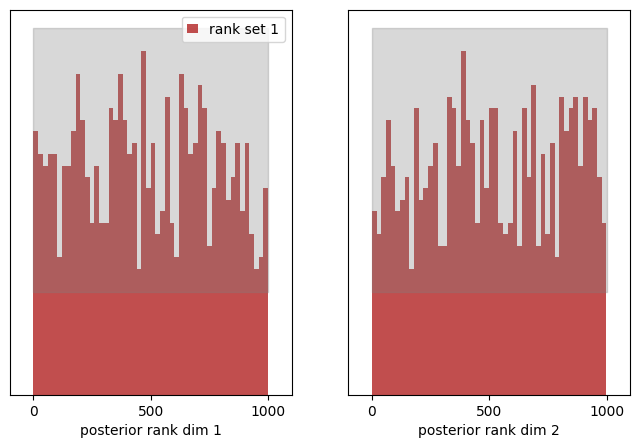

In [15]:
from sbi.analysis import sbc_rank_plot

f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
)

The two plots visualize the distribution of `ranks` (here depicted in red) in each dimension. Highlighted in grey you see the 99% confidence interval of a uniform distribution given the number of samples provided. In plain english: for a uniform distribution, we would expect 1 out of 100 (red) bars to lie outside the grey area.

We also observe, that the entries fluctuate to some degree. This can be considered a hint that `sbc` should be conducted with a lot more samples than 1000. A good rule of thumb is that given the number of bins `B` and the number of SBC samples `N` (chosed to be `1_000` here) should amount to `N / B ~ 20`.

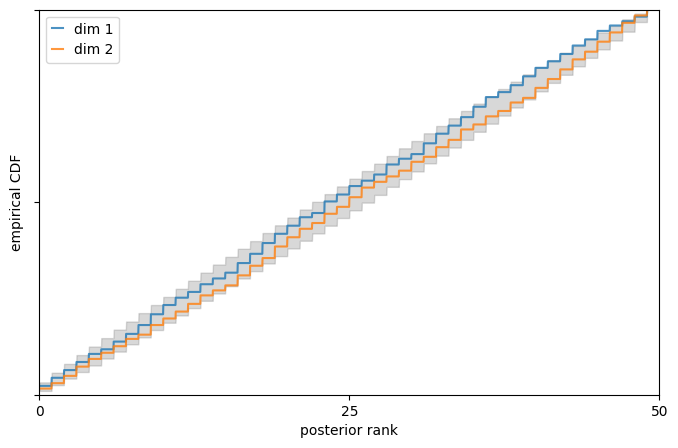

In [16]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf")

The above provides a visual representation of the cumulative density function (CDF) of `ranks` (blue and orange for each dimension of `theta`) with respect to the 95% confidence interval of a uniform distribution (grey).

# When things go haywire

Next, we would like to explore some pathologies visible in sbc plots which can hint at our estimated posterior being somewhat wrong or completely off.

## A shifted posterior mean

In this scenario we emulate the situation that our posterior estimates incorrectly with a constant shift. We reuse our trained NPE posterior from above and wrap it so that all samples returned expose a constant shift by `+0.1`.

In [16]:
from utils_13_diagnosis_sbc import BiasedPosterior

# this posterior shifts the expected value of the prior by .1
posterior_ = BiasedPosterior(posterior, shift=0.1)

In [17]:
ranks, dap_samples = run_sbc(thetas, xs, posterior_)
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)
print(check_stats)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

{'ks_pvals': tensor([0., 0.]), 'c2st_ranks': tensor([0.6815, 0.6730]), 'c2st_dap': tensor([0.5025, 0.4935])}


We can see that the Kolmogorv-Smirnov p-values vanish (`'ks_pvals': tensor([0., 0.])`). Thus, we can reject the hypothesis that the `ranks` PDF is the uniform PDF. The `c2st` accuracies show values higher than `0.5`. This is indicative that the `ranks` distribution is not a uniform PDF as well.

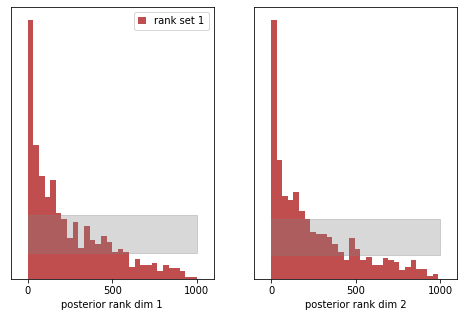

In [18]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="hist", num_bins=30)

Inspecting the histograms for both dimenions, the rank distribution is clearly tilted to low rank values for both dimensions. Because we have shifted the expected value of the posterior to higher values (by `0.1`), we see more entries at low rank values.

Let's try to shift all posterior samples in the opposite direction. We shift the expectation value by `-0.1`:

In [19]:
posterior_ = BiasedPosterior(posterior, shift=-0.1)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

{'ks_pvals': tensor([0., 0.]), 'c2st_ranks': tensor([0.6795, 0.6955]), 'c2st_dap': tensor([0.4910, 0.4955])}


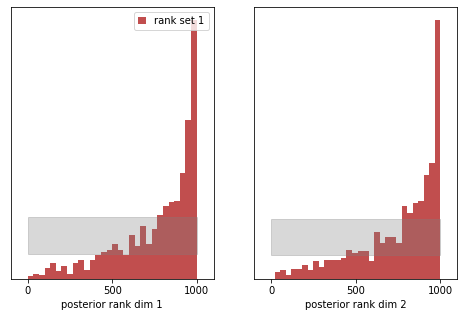

In [20]:
ranks, dap_samples = run_sbc(thetas, xs, posterior_)
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)
print(check_stats)
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="hist", num_bins=30)

A similar behavior is observed, but this time we see an upshot of ranks to higher values. Because we have shifted the expected value of the posterior to smaller values, we see an upshot in high rank counts.

It is interesting to see that the historgams obtained provide very convincing evidence that this is not a uniform distribution. 

To conlude at this point, **the rank distribution is capable of identifying pathologies of the estimated posterior**:

+ a **left-skewed rank distribution** shows a systematic **underestimation of the posterior mean**  
(we shifted the posterior by `0.1`)
+ a **rank-skewed rank distribution** shows a systematic **overestimation of the posterior mean**  
(we shifted the posterior by `-0.1`)

## A dispersed posterior

In this scenario we emulate the situation if our posterior estimates incorrectly with a dispersion, i.e. the posterior is too wide or too thin. We reuse our trained NPE posterior from above and wrap it so that all samples return a dispersion by 100% more wide (`2`), i.e. the variance is overestimated by a factor of 2.

In [21]:
from utils_13_diagnosis_sbc import DispersedPosterior

# this posterior which disperses the expected posterior value of the prior by 2.
posterior_ = DispersedPosterior(posterior, dispersion=2.0)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

{'ks_pvals': tensor([8.2151e-09, 6.9635e-07]), 'c2st_ranks': tensor([0.6150, 0.6160]), 'c2st_dap': tensor([0.5050, 0.4905])}


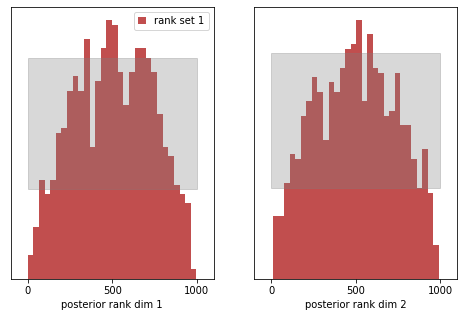

In [22]:
ranks, dap_samples = run_sbc(thetas, xs, posterior_)
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)
print(check_stats)
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="hist", num_bins=30)

The rank histograms now look more like a very wide gaussian distribution centered in the middle. The KS p-values again vanish unsurprisingly (we must reject the hypothesis that both distributions are from the same uniform PDF) and the c2st_ranks indicate that the rank histogram is not uniform too. As our posterior samples are distributed too broad now, we obtain more "medium" range ranks and hence produce the peak of ranks in the center of the histogram.

We can repeat this exercise by making our posterior too thin, i.e. the variance of the posterior is too small. Let's cut it by half.

In [23]:
posterior_ = DispersedPosterior(posterior, dispersion=0.5)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

{'ks_pvals': tensor([1.1753e-07, 1.7929e-08]), 'c2st_ranks': tensor([0.5755, 0.6125]), 'c2st_dap': tensor([0.4980, 0.5075])}


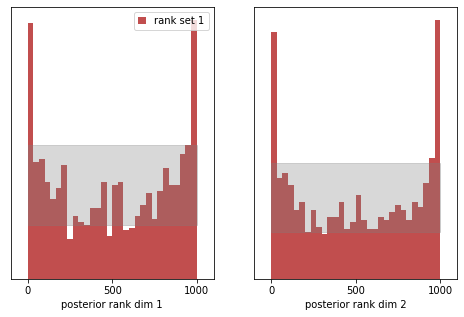

In [24]:
ranks, dap_samples = run_sbc(thetas, xs, posterior_)
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)
print(check_stats)
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="hist", num_bins=30)

The histogram of ranks now shoots above the allowed (greyed) area for a uniform distributed around the extrema. We made the posterior samples too thin, so we received more extreme counts of ranks. The KS p-values vanish again and the `c2st` metric of the ranks is also larger than `.5` which underlines that our rank distribution is not uniformly distributed.

We again see, **the rank distribution is capable of identifying pathologies of the estimated posterior**:

+ a **centrally peaked rank distribution** shows a systematic **over-estimation of the posterior variance**  
(we dispersed the variance of the posterior by a factor of `2`)
+ a **U shaped rank distribution** shows a systematic **under-estimation of the posterior variance**  
(we dispersed the variance of the posterior by a factor of `.5`)


Simulation-based calibration offers a direct handle on which pathology an estimated posterior examines. Outside of this tutorial, you may very well encounter situations with mixtures of effects (a shifted mean and over-estimated variance). Moreover, uncovering a malignant posterior is only the first step to fix your analysis. 